In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Voice_Vertification

/content/drive/MyDrive/Voice_Vertification


In [4]:
!pip install pydub

In [5]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
import random 
import glob

# 1. Utils 

- In this section, I wanna look into the data to have more understand about it. I'll do some examine:
  - Folder `Dataset` contains 400 subjects corresponding to `400` people. Each will have about `5-20` speech. 
  - Loading certain wave files and `visualize` them both in time domain and frequency domain (`mfccs` in details)
  - Also, `splitting` the wav files into multiple wave files(set the `time_sample = 1.5s`) 
  - Next, `adding some noise` to the data is taken into account
  - `Zero-Padding` at both directions is also necessary

In [6]:
DATA_ROOT = 'Zalo_Voice_Verification/Train-Test-Data/dataset'
subject_foders = os.listdir(DATA_ROOT)
print(len(subject_foders))
test_subject_folder =  os.path.join(DATA_ROOT, random.choice(subject_foders)) 

400


In [7]:
test_audio_file1 = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file1)

In [8]:
test_audio_file = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file)

In [9]:
print(test_audio_file)

Zalo_Voice_Verification/Train-Test-Data/dataset/629-F-24/629-4.wav


In [10]:
signal, sr = librosa.load(test_audio_file1,sr=16000)

In [11]:
print(len(signal)/sr)

1.425125


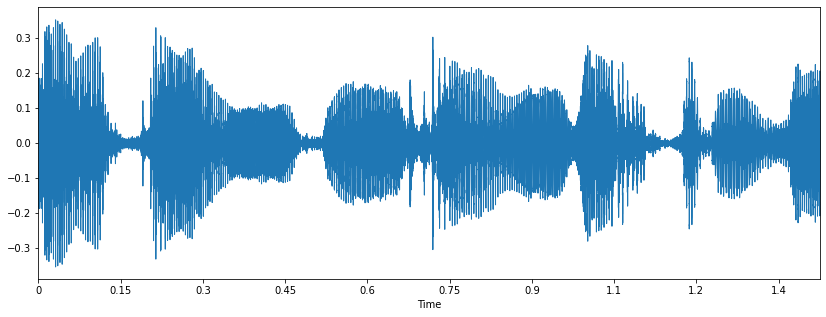

In [12]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [13]:
from pydub import AudioSegment
import os

save_folder='splitaudio'

def split(i,test_audio_file,save_folder='splitaudio'):
  subject_folder = '/'.join(test_audio_file.split('/')[:-1])
  save_folder = os.path.join(subject_folder,save_folder)
  try:
    os.rmdir(save_folder)
  except:
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
  audio = AudioSegment.from_file(test_audio_file)
  lengthaudio = len(audio)
  start = 0
  threshold = 1500 # 1.5s
  end = 0
  counter = 0

  while start < len(audio):
      end += threshold
      chunk = audio[start:end]
      filename = f'{i}_chunk{counter}.wav' 
      filename = os.path.join(save_folder,filename)
      try:
        chunk.export(filename, format="wav")
      except:
        pass
      counter +=1
      start += threshold


In [ ]:
'''
for subject_foder in tqdm(subject_foders):
  print(subject_foder)
  subject_foder = os.path.join(DATA_ROOT, subject_foder)
  wav_paths = glob.glob(os.path.join(subject_foder,'*.wav'))
  for i,wav_path in enumerate(wav_paths):
    split(i,wav_path,save_folder='splitaudio')
'''

In [15]:
test_subject_folder = os.path.join(test_subject_folder,save_folder)
test_audio_file = os.path.join(test_subject_folder,random.choice(os.listdir(test_subject_folder)))
ipd.Audio(test_audio_file)

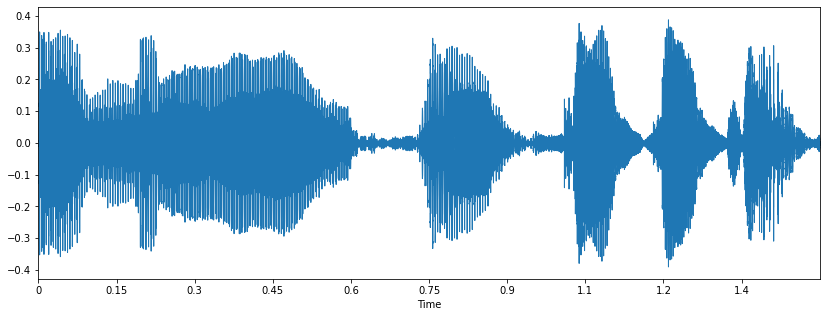

In [16]:
signal, sr = librosa.load(test_audio_file,sr=16000)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr)

In [17]:
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr,n_fft=2048)
print(len(signal)/sr)
print(len(signal))

1.5
24000


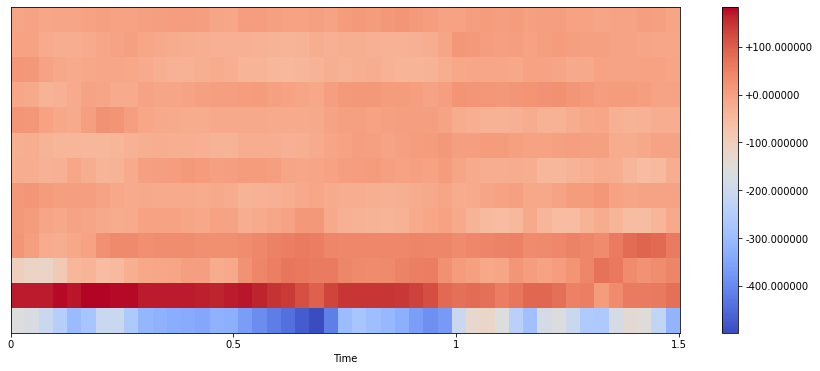

In [18]:
plt.figure(figsize=(15,6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [19]:
mfccs = mfccs/np.linalg.norm(mfccs)
noise = np.random.normal(0, .001, mfccs.shape)
new_mfccs = mfccs + noise

In [20]:
new_mfccs.shape

(13, 47)

In [ ]:
plt.figure(figsize=(15,6))
librosa.display.specshow(new_mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [22]:
MAX_LEN = 47
seq = new_mfccs.shape[1]
new_mfccs = new_mfccs
if seq<MAX_LEN:
  pad = np.zeros((new_mfccs.shape[0],MAX_LEN-seq))
  new_mfccs = np.concatenate([new_mfccs,pad],axis = 1)

In [23]:
new_mfccs.shape

(13, 47)

In [ ]:
plt.figure(figsize=(15,6))
librosa.display.specshow(new_mfccs, x_axis='time', sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [25]:
new_mfccs = np.stack((new_mfccs,)*3, axis=-1)
print(new_mfccs.shape)

(13, 47, 3)


In [26]:
paths = glob.glob(DATA_ROOT+'/*/splitaudio/*.wav')

In [27]:
import random
random.shuffle(paths)

In [28]:
print(len(paths))

19440


In [29]:
def get_prefix(file):
  split = file.split('/')
  return '/'.join(split[:-1]),split[-3]

In [30]:
print(get_prefix(paths[0]))

('Zalo_Voice_Verification/Train-Test-Data/dataset/578-M-38/splitaudio', '578-M-38')


# 2. Dataset

- In this section, I will create a custom dataset which consists of `19440` file pairs and corresponding label. This's gonna take pretty much time to train !!!
- I will set `sample rate` = 16000, `n_mfcc` = 13, and `MAX_LEN` = 47.
- To avoid imbalanced dataset, I try to random label (0,1) before choosing pair.


In [31]:
def get_data_file(wave_paths,save_file = 'data.txt',limit = 6000,subjects = np.array(subject_foders)):
  with open(save_file,'w') as f:
    total = []
    for idx in range(limit):
      random.shuffle(paths)
      file1 = wave_paths[idx]
      predix, subject1= get_prefix(file1)
      label = random.choice([0,1]) 
      if label == 1:
        wav_files = np.array(glob.glob(predix+'/*.wav'))
        other_wav_files = wav_files[wav_files!=file1]
        file2 = random.choice(other_wav_files)
      else:
        other_folders = subjects[subjects!=subject1]
        predix_2 = predix.replace(subject1,random.choice(other_folders))
        file2 = random.choice(glob.glob(predix_2+'/*.wav'))
      if file1.endswith('wav') and file1.endswith('wav'):
        text = file1+';'+file2+';'+str(label)+'\n'
        if text not in total:
          total.append(text)
          f.write(total[-1])

In [32]:
# get_data_file(paths)

In [33]:
with open('data.txt','r') as f:
  data = f.readlines()
  for item in data:
    item = item[:-1]
    file1,file2,_ = item.split(';')
    print(file1)
    break

Zalo_Voice_Verification/Train-Test-Data/dataset/580-F-23/splitaudio/28_chunk0.wav


In [63]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2

class VoiceData(Dataset):

  def __init__(self,data = data, sr = 16000,n_mfcc=13,resize = False,img_size = 112):
    super(VoiceData, self).__init__()
    self.sr = sr
    self.MAX_LEN = MAX_LEN
    self.n_mfcc = n_mfcc
    self.data = data
    self.resize = resize
    self.img_size = img_size

  def __len__(self):
    return len(self.data)

  def extract(self,file):
    signal, sr = librosa.load(file,sr=self.sr)
    nfft = len(signal) - 1 
    mfccs = librosa.feature.mfcc(signal, n_mfcc=self.n_mfcc, sr=sr , n_fft= nfft)
    mfccs = mfccs/np.linalg.norm(mfccs)
    noise = np.random.normal(0, .0001, mfccs.shape)
    new_mfccs = mfccs #+ noise
    seq = new_mfccs.shape[1]
    if seq<self.MAX_LEN:
      pad = np.zeros((new_mfccs.shape[0],self.MAX_LEN-seq))
      new_mfccs = np.concatenate([new_mfccs,pad],axis = 1)
    new_mfccs = np.stack((new_mfccs,)*3, axis=-1)
    if self.resize:
      new_mfccs=cv2.resize(new_mfccs,(self.img_size,self.img_size))
    return new_mfccs

  def __getitem__(self,idx):    
    item = self.data[idx]
    file1,file2,label = item[:-1].split(';')
    file1_mfccs = self.extract(file1)
    file1_mfccs = torch.FloatTensor(file1_mfccs)
    file2_mfccs = self.extract(file2)
    file2_mfccs = torch.FloatTensor(file2_mfccs)
    return file1_mfccs.permute(2,0,1),file2_mfccs.permute(2,0,1),torch.FloatTensor([int(label)])

In [64]:
TEST_SIZE = 0.2
BATCH_SIZE = 64
NUM_WORKERS = 2

In [65]:
# train_dataset = VoiceData(data=data[int(TEST_SIZE * len(data)):])
# val_dataset = VoiceData(data=data[:int(TEST_SIZE * len(data))])
train_dataset = VoiceData(data=data[:1000])
val_dataset = VoiceData(data=data[1000:1200])

In [66]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
)

val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
)

In [67]:
# item = iter(val_loader).next()
# print(item[2])

# 3. Model

- I will implement a simple Siamese Network including some Convolutional layers as well as Batchnorm, Dropout followed by 3 dense layers
- Input size would be `(BATCH_SIZE,1,img_size,img_size)`

In [68]:
import torch.nn as nn  
import torch.nn.functional as F


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=.2),
            
            nn.Conv2d(16, 32, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),

            nn.Conv2d(32, 32, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=.2),
        )
        self.fc1 = nn.Linear(34112, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)


    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        
        output = torch.cat((output1, output2),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
from torchsummary import summary

in1 = torch.randn((1,3,13,47))
in2 = torch.randn((1,3,13,47))
model = SiameseNetwork()
print(model(in1,in2))
summary(model, [(3, 13, 47),(3, 13, 47)],device = 'cpu')

# 4. Train

In [103]:
device = 'cuda'
EPOCH_N = 100
LEARNING_RATE = 0.0001
ckpt = 'model1.pth'

In [ ]:
try:
  model.load_state_dict(torch.load(ckpt))
except:
  pass

model = model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
BEST_LOSS = 9999
for epoch in range(EPOCH_N):
  train_loss_epoch = 0
  model.train()
  for em1,em2,label in tqdm(train_loader):
    em1 = em1.to(device)
    em2 = em2.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    out = model(em1,em2)
    loss = criterion(out,label)
    train_loss_epoch+=loss.item()
    loss.backward()  
    optimizer.step()

  model.eval()
  val_loss_epoch = 0
  with torch.no_grad():
    for em1,em2,label in tqdm(val_loader):
      em1 = em1.to(device)
      em2 = em2.to(device)
      label = label.to(device)
      out = model(em1,em2)
      loss = criterion(out,label)
      val_loss_epoch+=loss.item()
  if val_loss_epoch < BEST_LOSS:
    BEST_LOSS = val_loss_epoch
    torch.save(model.state_dict(),ckpt)
  print("------------------------>>>>>>>", train_loss_epoch, "----------->>>>>>>", val_loss_epoch)


  0%|          | 0/16 [00:00<?, ?it/s]

# 5. Test

In [79]:
'''
public_test_folder =  'Voice_Vertification/Zalo_Voice_Verification/Train-Test-Data/public-test'
test_wav_files = glob.glob(os.path.join(public_test_folder,'*.wav'))
for wav_path in test_wav_files:
  save_folder = wav_path.split('/')[-1][:-4]
  split(0,wav_path,save_folder=save_folder)
'''

In [ ]:
# model = SiameseNetwork()

try:
  model.load_state_dict(torch.load(ckpt))
except:
  pass

model.eval()

In [83]:
import pandas as pd

public_test = 'Zalo_Voice_Verification/Train-Test-Data/public-test.csv'
test_files = pd.read_csv(public_test)
test_wave_folder = 'Zalo_Voice_Verification/Train-Test-Data/public-test'

test_files['audio_1'] = test_files['audio_1'].apply(lambda x: os.path.join(test_wave_folder, x[:-4]))
test_files['audio_2'] = test_files['audio_2'].apply(lambda x: os.path.join(test_wave_folder, x[:-4]))

In [ ]:
import torch.nn.functional as F

THRESHOLD = 0.05
SAVE_FILE = 'result.txt'

def extract(file):
    signal, sr = librosa.load(file,sr=16000)
    nfft = len(signal) - 1 
    mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr , n_fft= nfft)
    mfccs = mfccs/np.linalg.norm(mfccs)
    seq = mfccs.shape[1]
    if seq<MAX_LEN:
      pad = np.zeros((mfccs.shape[0],MAX_LEN-seq))
      mfccs = np.concatenate([mfccs,pad],axis = 1)
    mfccs = np.stack((mfccs,)*3, axis=-1)
    mfccs = torch.FloatTensor(mfccs).permute(2,0,1)
    return mfccs


with open(SAVE_FILE,'a') as f:
  with torch.no_grad():
    for test1,test2 in tqdm(zip(test_files['audio_1'].to_numpy(),test_files['audio_2'].to_numpy())):
      file1 = random.choice(glob.glob(test1+'/*.wav'))
      file2 = random.choice(glob.glob(test2+'/*.wav'))
      em1 = extract(file1)
      em2 = extract(file2)
      em1 = em1.to(device)
      em2 = em2.to(device)
      em1 = torch.unsqueeze(em1,dim = 0)
      em2 = torch.unsqueeze(em2,dim = 0)
      out = model(em1,em2)
      out = 1 if out > THRESHOLD else 0
      f.write(str(out)+'\n')